<a href="https://colab.research.google.com/github/dhirajsuvarna/nlp_text_classification/blob/master/hackathon/ULMFit_Drug_Review_Classification_Try_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading DataSet from Google Drive

In [3]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.text import * 

#Load the Traning and Validation Dataset
df_train = pd.read_csv('/content/drive/My Drive/Projects/AnalyticsHackathon/dataset/drugsComTrain_raw.csv')
df_valid = pd.read_csv('/content/drive/My Drive/Projects/AnalyticsHackathon/dataset/drugsComTest_raw.csv')

##Removing Empty Cells and Invalid Cells





In [6]:
df_train = df_train[['condition', 'review']]
df_valid = df_valid[['condition', 'review']]
print (f"#Train Examples: {df_train.shape}")
print (f"#Validation Examples: {df_valid.shape}")

#print(df_train[df_train['condition'].isna()])
print(f"#NaN in Train: {df_train[df_train['condition'].isna()].shape}")
print(f"#NaN in Validation: {df_valid[df_valid['condition'].isna()].shape}")

#Reomve the rows with empty(nan) 'condition' or empty(nan) 'review'
print("Removing rows with nan values...")
df_train = df_train.dropna()
df_valid = df_valid.dropna()

#print(df_train[df_train['condition'].str.contains('users found this comment helpful')])
print(f"#'users found this comment useful' in Train: {df_train[df_train['condition'].str.contains('users found this comment helpful')].shape}")
print(f"#'users found this comment useful'in Validation: {df_valid[df_valid['condition'].str.contains('users found this comment helpful')].shape}")

#Remove the rows where 'condition' is "users found this comment helpful"
print("Removing the rows where condition is 'users found this comment helpful'")
df_train = df_train[~df_train['condition'].str.contains('users found this comment helpful')]
df_valid = df_valid[~df_valid['condition'].str.contains('users found this comment helpful')]

df_train = df_train[['condition', 'review']]
df_valid = df_valid[['condition', 'review']]
print (f"#Train Examples: {df_train.shape}")
print (f"#Validation Examples: {df_valid.shape}")

#Train Examples: (161297, 2)
#Validation Examples: (53766, 2)
#NaN in Train: (899, 2)
#NaN in Validation: (295, 2)
Removing rows with nan values...
#'users found this comment useful' in Train: (900, 2)
#'users found this comment useful'in Validation: (271, 2)
Removing the rows where condition is 'users found this comment helpful'
#Train Examples: (159498, 2)
#Validation Examples: (53200, 2)


##Making the Traning Set Smaller for Quick Experiments

In [0]:
# #Creating a smaller version of dataset for quick setup of framework
# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_valid = df_valid.sample(frac=1).reset_index(drop=True)

# df_train = df_train[:1000]
# df_valid = df_valid[:200]
# print(df_train.shape)
# print(df_valid.shape)


##Remove Mismatch of Classes between Validation and Training Set

In [7]:
#Number of classes present in the training and validation set
targets_train = df_train['condition'].unique()
targets_valid = df_valid['condition'].unique()
print(f"#Target Classes in Train: {len(targets_train)}")
print(f"#Target Classes in Validation: {len(targets_valid)}")

targets_only_in_valid = [item for item in targets_valid if item not in targets_train]
print(f"#Targets in Validation but not in Training: {len(targets_only_in_valid)}")


#Target Classes in Train: 811
#Target Classes in Validation: 664
#Targets in Validation but not in Training: 25


In [8]:
#Remove the items from Validation Set for which classes are present in Validation but not present in the Training Set
print(f"#Invalid Validation examples: {df_valid[df_valid['condition'].isin(targets_only_in_valid)].shape}")

df_valid = df_valid[~df_valid['condition'].isin(targets_only_in_valid)]

df_train = df_train[['condition', 'review']]
df_valid = df_valid[['condition', 'review']]
print (f"#Train Examples: {df_train.shape}")
print (f"#Validation Examples: {df_valid.shape}")

#Invalid Validation examples: (39, 2)
#Train Examples: (159498, 2)
#Validation Examples: (53161, 2)


In [9]:
#Check the Classes which are present in the Training Set but not present in the Validation Set
targets_only_in_train = [item for item in targets_train if item not in targets_valid]
print(f"#Targets in Training but not in Validation: {len(targets_only_in_train)}")

df_only_in_train = df_train[df_train['condition'].isin(targets_only_in_train)]
print(f"Training Examples only in Training Set: {df_only_in_train.shape}")

print(df_only_in_train['condition'].value_counts())

#Targets in Training but not in Validation: 172
Training Examples only in Training Set: (419, 2)
Bronchiectasis                         13
Pulmonary Embolism, Recurrent Event     9
Brain Tum                               8
Atherosclerosis                         8
Lyme Disease, Arthritis                 8
                                       ..
Epicondylitis, Tennis Elbow             1
Neuritis                                1
Linear IgA Disease                      1
ungal Pneumonia                         1
Hydrocephalus                           1
Name: condition, Length: 172, dtype: int64


In [10]:
#We can see that there are 419 Training examples for which 172 classes are present in Traning set but not the validation set
#To make the Traning and Validation Set Balanced, removing those 419 Traning Examples 
df_train = df_train[~df_train['condition'].isin(targets_only_in_train)]

df_train = df_train[['condition', 'review']]
df_valid = df_valid[['condition', 'review']]
print (f"#Train Examples: {df_train.shape}")
print (f"#Validation Examples: {df_valid.shape}")

#Train Examples: (159079, 2)
#Validation Examples: (53161, 2)


##Cleaning up Review Comments

In [0]:
#Perform basic cleaning operation on the review comments 
#mainly to convert the HTML Code Characters to the actual charcters
import html

# #SAVE TO CSV to see the changes with ur naked eyes
# df_train['clean_review'] = df_train['review'].apply(html.unescape)
# df_valid['clean_review'] = df_valid['review'].apply(html.unescape)
# df_train.to_csv('./drugsComTrainClean_raw.csv')
# df_train.to_csv('./drugsComTestClean_raw.csv')

df_train['review'] = df_train['review'].apply(html.unescape)
df_valid['review'] = df_valid['review'].apply(html.unescape)

#print(df_train[df_train['condition'] == "Depression"])


##Summary of the Data

In [12]:
print (f"Shape of Cleaned up Train Set: {df_train.shape}")
print (f"Shape of Cleaned up  Validation Set: {df_valid.shape}")

#Number of classes present in the training and validation set
targets_train = df_train['condition'].unique()
targets_valid = df_valid['condition'].unique()
print(f"#Target Classes in Train: {len(targets_train)}")
print(f"#Target Classes in Validation: {len(targets_valid)}")


Shape of Cleaned up Train Set: (159079, 2)
Shape of Cleaned up  Validation Set: (53161, 2)
#Target Classes in Train: 639
#Target Classes in Validation: 639


##Visualizing the Data
(not so visual for now)

In [13]:
#Visualize the dataspread for each of the classes 
#print(df_train.groupby(['condition']).size().reset_index(name='count').sort_values(['count'], ascending=False))
print(df_train['condition'].value_counts())
print(df_valid['condition'].value_counts())

Birth Control                              28788
Depression                                  9069
Pain                                        6145
Anxiety                                     5904
Acne                                        5588
                                           ...  
Dissociative Identity Disorde                  1
Mycoplasma Pneumonia                           1
Radionuclide Myocardial Perfusion Study        1
Gallbladder Disease                            1
Myelofibrosis                                  1
Name: condition, Length: 639, dtype: int64
Birth Control                                   9648
Depression                                      3095
Pain                                            2100
Anxiety                                         1908
Acne                                            1847
                                                ... 
Glioblastoma Multi                                 1
Hyperkalemia                                   

##Start ULMFit Stuff

In [0]:
#Prepare for training the language model
#todo: i have not specified batch size(bs)
data_lm = TextLMDataBunch.from_df(path='/', train_df=df_train, valid_df=df_valid)
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


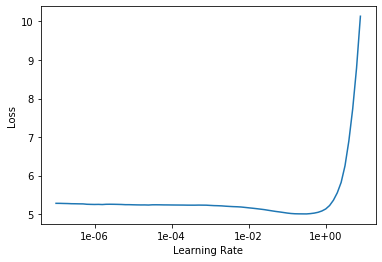

In [15]:
#find the learning rate 
learn_lm.lr_find(start_lr=1e-8, end_lr=1e2)
learn_lm.recorder.plot()

In [16]:
#The above plot tells us that loss is minimum at the learning rate of 
#approx 1e0, so we need to choose the learning rate as one level before

#Start training the language model
learn_lm.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))



epoch,train_loss,valid_loss,accuracy,time
0,3.683284,3.532496,0.306265,12:08


In [17]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(3, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.240383,3.142065,0.354504,13:56
1,3.094663,2.989730,0.374006,14:02
2,2.978294,2.944170,0.380486,14:00


In [0]:
#Plot the curves for language model - if necessary


In [18]:
#See how the language model is doing on the statement of medical review 
#write some string
medical_review = "I have been continuing this medicine for the last couple of months but"
learn_lm.predict(medical_review, n_words=10)

'I have been continuing this medicine for the last couple of months but can still see the change . Well i hope'

In [0]:
#fine tuned language model is called as encoder - we need to save it
learn_lm.save_encoder('ft_enc')

In [0]:
#Prepare for training the classifier
data_clas = TextClasDataBunch.from_df(path='/', train_df=df_train, valid_df=df_valid, vocab=data_lm.train_ds.vocab, min_freq=1, bs=32)

learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn_clas.load_encoder('ft_enc')
learn_clas.freeze()




LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


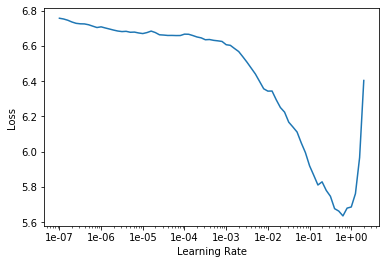

In [21]:
#find learning rate before starting the training of classifier
learn_clas.lr_find(start_lr=1e-8, end_lr=1e2)
learn_clas.recorder.plot()

In [22]:
#Start Training of the classifier 
# For training the classifier, "gradual unfreezing" should be applied to avoid "catastrophic forgetting"
# as explained in section 3.3 of Howard and Ruder's paper - https://arxiv.org/pdf/1801.06146.pdf 

learn_clas.freeze()
learn_clas.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.904567,1.669026,0.619778,04:38


In [23]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.791991,1.422388,0.663005,05:46


In [24]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.361937,1.296438,0.691484,09:25


In [25]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.441994,1.266849,0.696714,13:31
1,1.354515,1.205165,0.710145,12:56
2,1.107531,1.170206,0.720923,12:27


Buffered data was truncated after reaching the output size limit.

In [26]:
learn_clas.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.233560,1.212806,0.713794,12:25
1,1.070606,1.069522,0.749741,13:09


In [0]:
#Export the Learned Model
learn_clas.export('/content/drive/My Drive/Projects/AnalyticsHackathon/learned_classifer_try1.pkl')

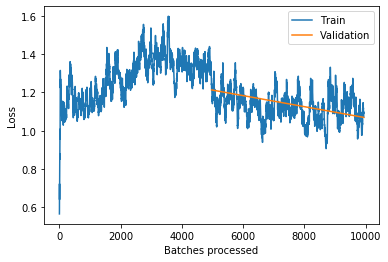

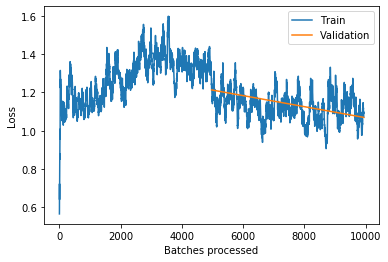

In [28]:
#Plot the curves for classifer model - should be done
learn_clas.recorder.plot_losses()

In [29]:
#Show Results: Acutal and Predicted 
learn_clas.show_results(rows=10)

text,target,prediction
"xxbos "" i do n’t find a lot of positive stories about antidepressants , or i find stories where people are taking the antidepressant the wrong way . \r \n \r \n i wanted to share my experience . a positive one . \r \n \r \n i ’ve had generalized anxiety disorder , xxup severe xxup ocd , and panic disorder for as long as i can",Obsessive Compulsive Disorde,Obsessive Compulsive Disorde
"xxbos "" • \t 19 xxmaj apr. 2016 \r\r \n \r\r \n xxmaj began initial dose at xxunk hours . xxmaj felt the medicine working within a ½ hour . xxmaj was in a good mood as i had been taken off of xxmaj warfarin this date . xxmaj before drifting off to sleep , i xxunk at the clock . xxmaj it was approx . xxunk hrs .",Depression,High Cholesterol
"xxbos "" xxmaj my personal experience with suboxone is good so far . i have been on prescribed xxmaj fentanyl xxmaj patch 25 much / 48 hrs . i have dropped to this dose over the last year . ( i also left the old patch on ) . i have been on opiates for 12 years full time prescribed . xxmaj at my highest prescription i was using 180",Opiate Dependence,Opiate Dependence
"xxbos "" xxmaj my personal experience with suboxone is good so far . i have been on prescribed xxmaj fentanyl xxmaj patch 25 much / 48 hrs . i have dropped to this dose over the last year . ( i also left the old patch on ) . i have been on opiates for 12 years full time prescribed . xxmaj at my highest prescription i was using 180",Opiate Dependence,Opiate Dependence
"xxbos "" xxmaj my colonoscopy was booked in for late afternoon on a xxmaj thursday . xxmaj the hospital said to stop eating anything from 1 pm on the xxmaj wednesday and recommended ( giving some detail ) a non fibre diet from xxmaj tuesday evening until xxmaj wednesday noon - avoiding dark drinks and jelly ( like blackcurrant flavour ) . xxmaj avoid red meat , sausages and pies",Bowel Preparation,Bowel Preparation
"xxbos "" xxmaj holy xxunk xxmaj batman it worked ! xxmaj but boy it was a xxmaj journey lol for 4 days i had n't pooped ! i had already taken laxatives , stool softener , a bucket of prunes , fiber pills , other fiber pills and still no poop over the last 4 days ! xxmaj so i called friend that has xxmaj gastroparesis and asked her what",Constipation,Constipation
"xxbos "" i just started this medicine 3 days ago and i can not express how much of an effect it has had on me already . i just graduated high school and became depressed soon after , severe anxiety where i could n't go out to eat without having to vomit . i also could n't keep focus on anything , especially when trying to talk to people ,",Depression,Depression
"xxbos "" i felt compelled to write a review , as i was on topamax ( or should i say dopamax ? ! ) for about 2 years . i started this medication when i was 21 and was so desperate to find something that would actually help my on - going migraines . xxmaj personally , the side effect symptoms xxup far outweighed the benefits . i started out",Migraine Prevention,Migraine Prevention
"xxbos "" i have dealt with ups and downs , anxiety , social anxiety , depression etc . etc . for years . xxmaj my life overall is normal and i managed the episodes but i always knew they were there and did n't like feeling that way . i am married we have children combine that with everything else and it times it was just too much . xxmaj",Social Anxiety Disorde,Social Anxiety Disorde
"xxbos "" xxmaj yes , this medication works . xxmaj it works very well for chronic anxiety disorder and sudden onsets of severe panic attacks . xxmaj knowing what i know now , i wish with all my being it had never ever been prescribed to me , and without the absurd xxunk dozens of practitioners have portrayed . \r\r \n i 'm 32 and have been prescribed clonazopam",Anxiety,Anxiety


text,target,prediction
"xxbos "" i do n’t find a lot of positive stories about antidepressants , or i find stories where people are taking the antidepressant the wrong way . \r \n \r \n i wanted to share my experience . a positive one . \r \n \r \n i ’ve had generalized anxiety disorder , xxup severe xxup ocd , and panic disorder for as long as i can",Obsessive Compulsive Disorde,Obsessive Compulsive Disorde
"xxbos "" • \t 19 xxmaj apr. 2016 \r\r \n \r\r \n xxmaj began initial dose at xxunk hours . xxmaj felt the medicine working within a ½ hour . xxmaj was in a good mood as i had been taken off of xxmaj warfarin this date . xxmaj before drifting off to sleep , i xxunk at the clock . xxmaj it was approx . xxunk hrs .",Depression,High Cholesterol
"xxbos "" xxmaj my personal experience with suboxone is good so far . i have been on prescribed xxmaj fentanyl xxmaj patch 25 much / 48 hrs . i have dropped to this dose over the last year . ( i also left the old patch on ) . i have been on opiates for 12 years full time prescribed . xxmaj at my highest prescription i was using 180",Opiate Dependence,Opiate Dependence
"xxbos "" xxmaj my personal experience with suboxone is good so far . i have been on prescribed xxmaj fentanyl xxmaj patch 25 much / 48 hrs . i have dropped to this dose over the last year . ( i also left the old patch on ) . i have been on opiates for 12 years full time prescribed . xxmaj at my highest prescription i was using 180",Opiate Dependence,Opiate Dependence
"xxbos "" xxmaj my colonoscopy was booked in for late afternoon on a xxmaj thursday . xxmaj the hospital said to stop eating anything from 1 pm on the xxmaj wednesday and recommended ( giving some detail ) a non fibre diet from xxmaj tuesday evening until xxmaj wednesday noon - avoiding dark drinks and jelly ( like blackcurrant flavour ) . xxmaj avoid red meat , sausages and pies",Bowel Preparation,Bowel Preparation
"xxbos "" xxmaj holy xxunk xxmaj batman it worked ! xxmaj but boy it was a xxmaj journey lol for 4 days i had n't pooped ! i had already taken laxatives , stool softener , a bucket of prunes , fiber pills , other fiber pills and still no poop over the last 4 days ! xxmaj so i called friend that has xxmaj gastroparesis and asked her what",Constipation,Constipation
"xxbos "" i just started this medicine 3 days ago and i can not express how much of an effect it has had on me already . i just graduated high school and became depressed soon after , severe anxiety where i could n't go out to eat without having to vomit . i also could n't keep focus on anything , especially when trying to talk to people ,",Depression,Depression
"xxbos "" i felt compelled to write a review , as i was on topamax ( or should i say dopamax ? ! ) for about 2 years . i started this medication when i was 21 and was so desperate to find something that would actually help my on - going migraines . xxmaj personally , the side effect symptoms xxup far outweighed the benefits . i started out",Migraine Prevention,Migraine Prevention
"xxbos "" i have dealt with ups and downs , anxiety , social anxiety , depression etc . etc . for years . xxmaj my life overall is normal and i managed the episodes but i always knew they were there and did n't like feeling that way . i am married we have children combine that with everything else and it times it was just too much . xxmaj",Social Anxiety Disorde,Social Anxiety Disorde
"xxbos "" xxmaj yes , this medication works . xxmaj it works very well for chronic anxiety disorder and sudden onsets of severe panic attacks . xxmaj knowing what i know now , i wish with all my being it had never ever been prescribed to me , and without the absurd xxunk dozens of practitioners have portrayed . \r\r \n i 'm 32 and have been prescribed clonazopam",Anxiety,Anxiety


In [0]:
#Get the accuracy matrix 
predictions, targets = learn_clas.get_preds()

In [31]:
from sklearn import metrics

predictions_clas = np.argmax(predictions, axis = 1) 
print(predictions_clas.shape)
print(targets.shape)


torch.Size([53161])
torch.Size([53161])
torch.Size([53161])
torch.Size([53161])


In [32]:
predictions[0].shape

torch.Size([639])

torch.Size([639])

In [33]:
#Generate Confusion Matrix
confusion_matrix = metrics.confusion_matrix(targets, predictions_clas)
print(confusion_matrix)

#Export Confustion Matrix
df_confusion_matrix = pd.DataFrame(confusion_matrix)
df_confusion_matrix.to_csv('/content/drive/My Drive/Projects/AnalyticsHackathon/ULMFit_Drug_Review_Confusion_Matrix_try1.csv')

[[1022    0    0    0 ...    0    0    0    0]
 [   1    0    0    0 ...    0    0    0    0]
 [   0    0  378    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]
 ...
 [   0    0    0    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]
 [   0    0    2    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]]
[[1022    0    0    0 ...    0    0    0    0]
 [   1    0    0    0 ...    0    0    0    0]
 [   0    0  378    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]
 ...
 [   0    0    0    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]
 [   0    0    2    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]]


In [34]:
#From the confusion matrix, take diagnal elements

diag = np.diag(df_confusion_matrix)
correct_predictions = sum(diag)
total_validation_examples = np.sum(df_confusion_matrix, axis=1).sum()
pred_acc_percent = (correct_predictions/total_validation_examples) * 100
print(f"Sum of diagonal elements of the confusion matrix: {correct_predictions}")
print(f"Total number of vaildation examples: {total_validation_examples}")
print(f"Prediction Accuracy of the model: {pred_acc_percent}")


Sum of diagonal elements of the confusion matrix: 39863
Total number of vaildation examples: 53161
Prediction Accuracy of the model: 74.98542164368615
Sum of diagonal elements of the confusion matrix: 39863
Total number of vaildation examples: 53161
Prediction Accuracy of the model: 74.98542164368615


In [37]:
target_names = learn_clas.data.classes
print(metrics.classification_report(targets, predictions_clas, target_names=target_names))


                                                                precision    recall  f1-score   support

                                                          ADHD       0.83      0.91      0.86      1126
                                          AIDS Related Wasting       0.00      0.00      0.00         2
                                     Abnormal Uterine Bleeding       0.71      0.58      0.64       648
                                                      Abortion       0.00      0.00      0.00         2
                                        Acetaminophen Overdose       0.00      0.00      0.00         1
                                                          Acne       0.92      0.93      0.92      1847
                                             Actinic Keratosis       0.00      0.00      0.00         8
                                       Acute Coronary Syndrome       0.75      0.55      0.63        11
                                  Acute Lymphoblastic Leukemia 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:

a, b, c =learn_clas.predict("birth")
c.shape

torch.Size([639])

torch.Size([639])